In [2]:
temp_dir = "/Users/alexbindas/tmp"
json_directory_path = "../data/raw_data_84.tar.gz"

In [3]:
import shutil
shutil.rmtree(temp_dir)

In [4]:
import tarfile
import os
import shutil
import structlog
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, expr, when, udf, explode_outer, collect_list
from pyspark.sql.types import IntegerType, StringType, ArrayType, StructType, StructField, FloatType
from datetime import datetime

logger = structlog.get_logger()


# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Process JSON Files") \
    .getOrCreate()

# Read all JSON files from a directory
os.makedirs(temp_dir, exist_ok=True)

def extract_and_read_tar_gz(file_path):
    # Create a temporary directory to store extracted files
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=temp_dir)
    # Read all JSON files from the temporary directory
    json_df = spark.read.json(f"{temp_dir}/*.json", multiLine=True)
    return json_df

df = extract_and_read_tar_gz(json_directory_path)
df.cache()
logger.info("Dataframe initialized successfully.", count=df.count())
rdd = df.rdd


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/22 23:37:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/22 23:37:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


2024-04-22 23:38:22 [info     ] Dataframe initialized successfully. count=2756


In [5]:
df.printSchema()

root
 |-- activity: struct (nullable = true)
 |    |-- connections: string (nullable = true)
 |    |-- followers: string (nullable = true)
 |-- education: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- dates_attended: struct (nullable = true)
 |    |    |    |-- end: string (nullable = true)
 |    |    |    |-- start: string (nullable = true)
 |    |    |    |-- total_time: string (nullable = true)
 |    |    |-- degree: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- school_name: string (nullable = true)
 |-- education_count: long (nullable = true)
 |-- experience_count: long (nullable = true)
 |-- experiences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- company_name: string (nullable = true)
 |    |    |-- positions: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = t

In [6]:
pandas_df = df.toPandas()
# pandas_df.to_csv(f"/Users/alexbindas/linkedin_raw_data/uncleaned_data.csv", header=True)
pandas_df.head()

,activity,education,education_count,experience_count,experiences,id,last_generated_at,skills,skills_count
0,"(500+, 1K)","[((2025, 2024, None), [['Master of Science - M...",4,13,"[(Amazon, [Row(description='Summer 2024', end=...",8ba35d46-21dc-f6bf-5d41-576d1f187003,"April 22, 2024, 08:21 PM",[],0
1,"(500+, 886)","[(None, [['Doctor of Philosophy (PhD)', 'Biome...",4,8,"[(Publicis Groupe, [Row(description=None, end=...",ff31aa7e-7682-74ec-6dbe-8f6348ebfbb8,"April 22, 2024, 08:43 PM",[],0
2,"(500+, None)","[((2023, 2021, None), [['Master of Public Heal...",4,18,[(Yale Program on Climate Change Communication...,7657427a-3bc6-bda4-55dc-2c522bd2cf45,"April 22, 2024, 08:43 PM",[],0
3,"(500+, 721)","[((2026, 2022, None), [['Bachelor of Arts - BA...",4,10,"[(Harvard Undergraduate Data Analytics Group, ...",abacbb86-093f-d49d-187c-4de05634d337,"April 22, 2024, 08:43 PM",[],0
4,"(500+, 2K)","[((2024, 2022, None), [['Master of Science - M...",8,10,[(USC Annenberg School for Communication and J...,56dadc71-2fae-0839-fd56-c86507e1f79c,"April 22, 2024, 09:05 PM",[],0


In [5]:
import re

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, expr, when, udf
from pyspark.sql.types import IntegerType, StringType, ArrayType, FloatType
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
# -- Common --

def convert_to_std_date(date_str):
    if date_str is None:
        return None

    try:
        date_obj = datetime.strptime(date_str, "%b %Y")
    except ValueError:
        try:
            # Handle the case where only the year is provided
            date_obj = datetime.strptime(date_str, "%Y")
        except ValueError:
            return None

    standard_date = date_obj.strftime("%Y-%m-%d")
    return standard_date

def convert_text_to_number(s: str):
    '''
    Converts the text for followers and connections to a number,
    extracting the values out.
    '''
    if s is None:
        return 0
    try:
        s = s.strip().replace(',', '')
        if 'K' in s:
            s = s.replace('K', '')
            return int(float(s) * 1000)
        if 'M' in s:
            s = s.replace('M', '')
            return int(float(s) * 1000000)
        elif '+' in s:
            s = s.replace('+', '')
            return int(s)
    except ValueError:
        return 0
    return int(s)



# -- Education --
education_level_mapping = {
    'high school': 1,
    'certificate': 2,
    'associate': 3,
    'bachelor': 4,
    'master':5,
    'PhD': 6,
}
education_level_mapping_to_string = {v: k for k, v in education_level_mapping.items()}
def clean_degree_level(education) -> str| int:
    if not education:
        return None
    degree_list = education.degree[0]
    if not degree_list:
        return None
    degree = degree_list[0]
    degree = degree.strip().lower()
    school_name = education.school_name.strip().lower()
    if "high school" in school_name:
        # return 'high school diploma'
        return education_level_mapping.get("high school")
    if any([d in degree for d in ["master of science", "master", "ms", "m.s", "m.a.", "ma"]]):
        # return "master"
        return education_level_mapping.get("master")
    elif any([d in degree for d in ['doctor', 'phd']]):
        # return "PhD"
        return education_level_mapping.get("PhD")
        # return 5
    elif any([d in degree for d in ['bs', 'b.s', 'bachelor', 'b.a', 'ba', 'undergraduate']]):
        # return "bachelor"
        return education_level_mapping.get("bachelor")
    elif any([d in degree for d in ["associate's", "associate"]]):
    #   return "associate"
        return education_level_mapping.get("associate")
    elif any([d in degree for d in ["cert"]]):
        # return "certificate"
        return education_level_mapping.get("certificate")
    return 0
    # return f"not_classified::{degree}"

def clean_major(degree_list):
    if not degree_list:
        return 0
    major = degree_list.pop(-1)
    if any(char.isnumeric() for char in major):
        return 0
    return major

def get_degree_levels_list(education_list):
    if not education_list:
        return None
    degree_levels = []
    for _education_item in list(education_list):
        if not _education_item:
            continue
        degree_level = clean_degree_level(_education_item)
        degree_levels.append(degree_level)
    return degree_levels

def get_total_time_to_graduate(education_list):
    if not education_list:
        return None
    total_time_list = []
    for education in education_list:
        # Extract data from dates_attended
        end_year = None
        start_year = None
        total_years_to_complete = None
        if education.dates_attended:
            # Extract data from dates_attended
            end_year = education.dates_attended.end
            start_year = education.dates_attended.start
            try:
                if end_year and start_year:
                    total_years_to_complete = int(end_year) - int(start_year)
            except ValueError:
                print("Invalid type", education.dates_attended)
        total_time_list.append(total_years_to_complete)
    return total_time_list

# -- Experience --
job_level_mapping = {
    'student': 1,
    'tutor': 2,
    'TA': 3,
    'research assistant': 4,
    'intern': 5,
    'entry level': 6,
    'mid level': 7,
    'senior': 8,
    'director/vp': 9,
    'ceo/founder/president': 10,
    'consultant': 0
}
job_level_mapping_to_string = {v: k for k, v in job_level_mapping.items()}
def clean_job_level(position) -> str:
    if not position:
        return None
    job_title = position.job_title.strip().lower()
    if "intern" in job_title:
        return job_level_mapping.get('intern')
    elif any([t in job_title for t in ["student"]]):
        return job_level_mapping.get('student')
    elif job_title == 'ta' or any([t in job_title for t in ["teacher's assistant", "course assistant",
                                                            'teacher assistant', "teaching assistant",
                                                            'teachers assistant', "learning assistant"]]):
        return job_level_mapping.get('TA')
    elif any([t in job_title for t in ["research assistant"]]):
        return job_level_mapping.get('research assistant')
    elif any([t in job_title for t in ["jr.", "junior", 'entry', 'associate']]):
        return job_level_mapping.get('entry level')
    elif any([t in job_title for t in ["senior", 'sr.']]):
        return job_level_mapping.get('senior')
    elif any([t in job_title for t in ["director", 'vp', 'vice president', "chief", "cto"]]):
        return job_level_mapping.get('director/vp/chief/cto')
    elif any([t in job_title for t in ["tutor"]]):
        return job_level_mapping.get('tutor')
    elif any([t in job_title for t in ["consultant", "contractor"]]):
        return job_level_mapping.get('consultant')
    elif any([t in job_title for t in ["co-founder", 'founder', 'ceo', 'president']]):
        return job_level_mapping.get("ceo/founder/president")
    return
    # return f"not_classified"

def get_position_levels_list(experience_list):
    if not experience_list:
        return 0
    positions = []
    for i, experience in enumerate(experience_list):
        if not experience:
            continue
        for position in experience.positions:
            job_level = clean_job_level(position)
            if job_level:
                positions.append(job_level)
            else:
                positions.append(0)
    return positions

def get_position_start_dates(experience_list):
    if not experience_list:
        return None
    position_dates = []
    for i, experience in enumerate(list(experience_list)):
        if not experience:
            continue
        for position in experience.positions:
            if "year" not in position and "month" not in position:
                position_dates.append(position.start)
    return position_dates

def get_position_end_dates(experience_list):
    if not experience_list:
        return None
    position_dates = []
    for i, experience in enumerate(list(experience_list)):
        if not experience:
            continue
        for position in experience.positions:
            position_dates.append(position.end)
    return position_dates

def get_position_description(experience_list):
    if not experience_list:
            return None
    position_descriptions = []
    for i, experience in enumerate(list(experience_list)):
        if not experience:
            continue
        for position in experience.positions:
            if not position.description:
                position_descriptions.append(0)
            else:
                position_descriptions.append(position.description)
    return position_descriptions

def convert_to_months(duration_string):
    # Regular expressions to find years and months in the string
    years_regex = r'(\d+)\s*years?'
    months_regex = r'(\d+)\s*months?'

    # Find years and months in the duration string
    years_match = re.search(years_regex, duration_string)
    months_match = re.search(months_regex, duration_string)

    # Extract the number of years and months from the matches
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0

    # Convert the duration to months (add years converted to months)
    total_months = years * 12 + months
    return total_months

def calculate_months_between_dates(start_date_str, end_date_str):
    try:
        # Parse the start and end dates
        start_date = datetime.strptime(start_date_str, '%b %Y')
        end_date = datetime.strptime(end_date_str, '%b %Y')

        # Calculate the duration in months
        duration = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
        return max(duration, 0)
    except ValueError as e:
        print(f"Error calculating duration: {e}")
        return None


# Function to calculate total time given lists of start and end dates
def calculate_months_in_position(experience_list):
    if not experience_list:
        return None
    total_times = []
    start_dates = get_position_start_dates(experience_list)
    end_dates = get_position_end_dates(experience_list)

    for experience in list(experience_list):
        if not experience:
            continue
        for i, position in enumerate(experience.positions):
            if position.total_duration:
                duration = convert_to_months(position.total_duration)
                total_times.append(duration)
            else:
                start_date = start_dates[i] if start_dates else None
                end_date = end_dates[i] if end_dates else None
                if start_date is None and end_date is None:
                    total_times.append(0)
                elif start_date and ("year" in start_date or "month" in start_date):
                    duration = convert_to_months(start_date)
                    total_times.append(duration)
                elif end_date and ("year" in end_date or "month" in end_date):
                    duration = convert_to_months(end_date)
                    total_times.append(duration)
                else:
                    duration = calculate_months_between_dates(start_date, end_date)
                    total_times.append(duration)
    return total_times

def get_average_of_list(arr):
    if arr and len(arr) > 0:
        return float(np.mean(arr))
    else:
        return 0

# Register the UDF
calculate_months_in_position_udf = udf(calculate_months_in_position, ArrayType(IntegerType()))
clean_major_udf = udf(clean_major)
clean_degree_level_udf = udf(clean_degree_level, StringType())
convert_to_std_date_udf = udf(convert_to_std_date, StringType())
convert_text_to_number_udf = udf(convert_text_to_number, IntegerType())
get_degree_levels_list_udf = udf(get_degree_levels_list, ArrayType(IntegerType()))
get_position_levels_list_udf = udf(get_position_levels_list, ArrayType(IntegerType()))
get_total_time_to_graduate_udf = udf(get_total_time_to_graduate, ArrayType(StringType()))
get_position_start_dates_udf = udf(get_position_start_dates, ArrayType(StringType()))
get_position_end_dates_udf = udf(get_position_end_dates, ArrayType(StringType()))
get_position_description_udf = udf(get_position_description, ArrayType(StringType()))
get_average_of_list_udf = udf(get_average_of_list, FloatType())


## Latest Data - Dataframe

In [6]:
transformed_df = df.withColumn("followers", convert_text_to_number_udf(col("activity.followers"))) \
        .withColumn("degree_levels", get_degree_levels_list_udf(df.education))\
        .withColumn("years_to_graduate", get_total_time_to_graduate_udf(df.education))\
        .withColumn("position_levels", get_position_levels_list_udf(df.experiences))\
        .withColumn("position_start_dates", get_position_start_dates_udf(df.experiences))\
        .withColumn("position_end_dates", get_position_end_dates_udf(df.experiences))\
        .withColumn("position_description", get_position_description_udf(df.experiences))\
        .withColumn("year_of_graduation", df.education[0].dates_attended.end)\
        .withColumn("months_in_position", calculate_months_in_position_udf(df.experiences))\
        .withColumn("connections", convert_text_to_number_udf(col("activity.connections")))\
        .withColumn("degree", df.education[0].degree[0][0])\
        .withColumn("major", clean_major_udf(df.education[0].degree[0]))\
        .drop(*["activity", "last_generated_at", "education","experiences","skills"])

# pandas_df.to_csv(f"/Users/alexbindas/linkedin_raw_data/transformed_data.csv", header=True)
# transformed_df.show()
pandas_df = transformed_df.toPandas()
pandas_df.head()


,education_count,experience_count,id,skills_count,followers,degree_levels,years_to_graduate,position_levels,position_start_dates,position_end_dates,position_description,year_of_graduation,months_in_position,connections,degree,major
0,4,13,8ba35d46-21dc-f6bf-5d41-576d1f187003,0,1000,"[5, 4, 0, None]","[1, 4, 1, 4]","[5, 4, 0, 5, 0, 5, 5, 5, 0, 0, 0, 10, 0, 10, 0...","[Feb 2024, Jan 2024, Sep 2022, Jul 2023, Oct 2...","[3 months, 4 months, 1 year 8 months, Sep 2023...","[Summer 2024, Working under Sanmi Koyejo group...",2025,"[3, 3, 3, 3, 21, 3, 4, 3, 4, 4, 8, 13, 7, 9, 5...",500,Master of Science - MS,Computer Science
1,4,8,ff31aa7e-7682-74ec-6dbe-8f6348ebfbb8,0,886,"[6, 5, 4, 6]","[None, None, None, None]","[0, 0, 0, 8, 0, 0, 0, 0, 0, 1, 0]","[Dec 2023, 2023, 2021, 2019, 2017, 2017, 2016,...","[5 months, 2023, 2023, 2021, 2019, 2019, 2017,...","[0, In my capacity as the Head of Product Data...",None,"[5, 0, 24, 24, 24, 24, 12, 41, 24, 60, 12]",500,Doctor of Philosophy (PhD),"Biomedical Informatics, Bioinformatics, and Co..."
2,4,18,7657427a-3bc6-bda4-55dc-2c522bd2cf45,0,0,"[5, 4, 2, 1]","[2, 4, 0, 4]","[0, 4, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...","[May 2023, May 2022, Jan 2023, Dec 2022, Aug 2...","[1 year, 2 years, May 2023, May 2023, May 2023...","[0, Manage a multidisciplinary team of student...",2023,"[12, 12, 5, 6, 22, 3, 10, 3, 5, 18, 16, 9, 14,...",500,Master of Public Health - MPH,"Social and Behavioral Sciences, Climate Change..."
3,4,10,abacbb86-093f-d49d-187c-4de05634d337,0,721,"[4, 5, 5, None]","[4, 5, 9, 4]","[0, 6, 0, 5, 5, 5, 4, 0, 0, 5, 0, 0, 0, 0]","[Jan 2024, Sep 2023, Sep 2022, Jan 2024, Mar 2...","[4 months, Jan 2024, Sep 2023, 4 months, 1 yea...","[0, - Coordinated with the Case-Team Lead (CT...",2026,"[4, 5, 13, 4, 4, 4, 4, 4, 4, 3, 33, 13, 13, 2]",500,Bachelor of Arts - BA,"Applied Mathematics w/ Physics, CS Secondary"
4,8,10,56dadc71-2fae-0839-fd56-c86507e1f79c,0,2000,"[5, 5, 4, 5, 0, 0, 0, 0]","[2, 0, 4, 1, 0, 0, 2, 4]","[0, 0, 0, 0, 0, 5, 0, 0, 10, 5]","[May 2023, Jan 2023, May 2023, Jan 2023, Apr 2...","[1 year, Sep 2023, Aug 2023, Aug 2023, Apr 202...",[-Analyzed 100K+ of machine learning models an...,2024,"[12, 9, 4, 8, 13, 6, 19, 21, 9, 2]",500,Master of Science - MS,Product Development Engineering


In [8]:
from pyspark.sql.functions import col, max as spark_max, array_max, array_min, mean
from pyspark.sql import functions as F
# feature_cols = ['avg_time_in_position', 'max_time_in_position', 'min_time_in_position', 'followers', 'connections', 'highest_degree', 'highest_position', 'education_count', 'experience_count']
# reduction #1: Remove followers
feature_cols = ['avg_time_in_position', 'max_time_in_position', 'min_time_in_position', 'connections', 'highest_degree', 'highest_position', 'education_count', 'experience_count']

zero_conditions = [F.when(F.col(c) == 0, 1).otherwise(0) for c in feature_cols]
transformed_df_2 = transformed_df\
    .withColumn("highest_degree", array_max("degree_levels"))\
    .withColumn("highest_position", array_max("position_levels"))\
    .withColumn("max_time_in_position", array_max("months_in_position"))\
    .withColumn("min_time_in_position", array_min("months_in_position"))\
    .withColumn("avg_time_in_position", get_average_of_list_udf("months_in_position"))

transformed_df_2 = transformed_df_2.select(*feature_cols)\
    .withColumn('zero_count', sum(zero_conditions)).filter(F.col('zero_count') <= 1).drop("zero_count")

print(f"Total Count: {transformed_df_2.count()}")
transformed_df_2.toPandas().head()


Total Count: 2187


,avg_time_in_position,max_time_in_position,min_time_in_position,connections,highest_degree,highest_position,education_count,experience_count
0,6.062500,21.0,3.0,500,5.0,10.0,4,13
1,22.727272,60.0,0.0,500,6.0,8.0,4,8
2,9.857142,46.0,2.0,500,5.0,5.0,4,18
3,7.857143,33.0,2.0,500,5.0,6.0,4,10
4,10.300000,21.0,2.0,500,5.0,10.0,8,10


In [59]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator

filtered_df = transformed_df_2\
    .filter((F.col('highest_degree') != 0) | (F.col('highest_position') != 0))\
    .drop("id")
logger.info("Successfully filtered df", size=filtered_df.count())
# default_values = {k:0 for k in feature_cols}
# filtered_df = filtered_df.fillna(default_values)

assembler = VectorAssembler(
    inputCols= feature_cols,
    outputCol="features",
    handleInvalid='keep'
)
cost = []
k_means_range = range(2, 10)
for k in k_means_range:
    data = assembler.transform(filtered_df)
    print(f"Training model k-means (k={k})")
    num_clusters = k
    # Train KMeans model
    kmeans = KMeans(k=num_clusters)
    model = kmeans.fit(data)

    # Predict cluster assignments
    predictions = model.transform(data)
    preditions_pd_df = predictions.toPandas()
    preditions_pd_df
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    acc = evaluator.evaluate(predictions)
    cost.append(model.summary.trainingCost)
    print(f"Accuracy (Euclidean distance squared) -- accuracy={acc}")
    print("-------")



2024-04-22 23:01:02 [info     ] Successfully filtered df       size=2175


Training model k-means (k=2)


Accuracy (Euclidean distance squared) -- accuracy=0.8066703048479253
-------
Training model k-means (k=3)


Accuracy (Euclidean distance squared) -- accuracy=0.7228774328770764
-------
Training model k-means (k=4)


Accuracy (Euclidean distance squared) -- accuracy=0.6192708947773596
-------
Training model k-means (k=5)


Accuracy (Euclidean distance squared) -- accuracy=0.6907904703371579
-------
Training model k-means (k=6)


Accuracy (Euclidean distance squared) -- accuracy=0.6872186644543093
-------
Training model k-means (k=7)


Accuracy (Euclidean distance squared) -- accuracy=0.6588619179549478
-------
Training model k-means (k=8)


Accuracy (Euclidean distance squared) -- accuracy=0.7143033065730509
-------
Training model k-means (k=9)


Accuracy (Euclidean distance squared) -- accuracy=0.6781884504547196
-------


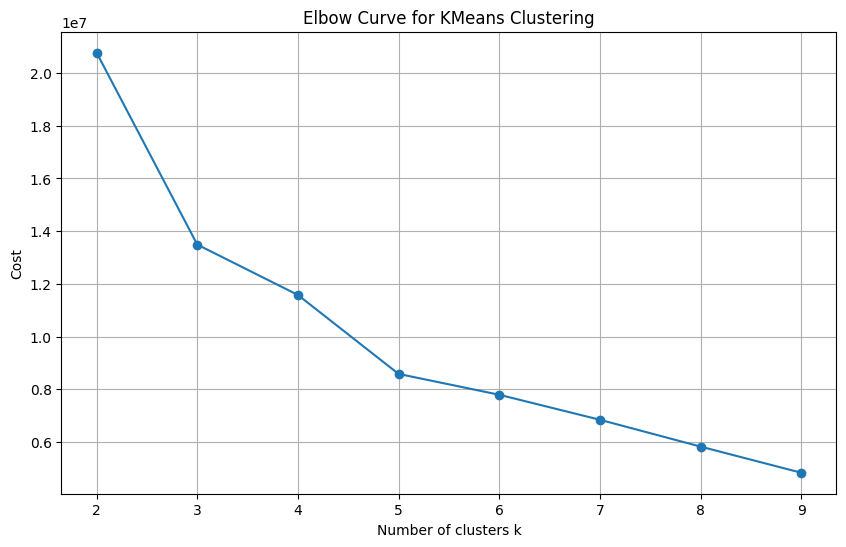

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(k_means_range, cost, marker='o')
plt.title('Elbow Curve for KMeans Clustering')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.xticks(k_means_range)
plt.grid(True)
plt.show()

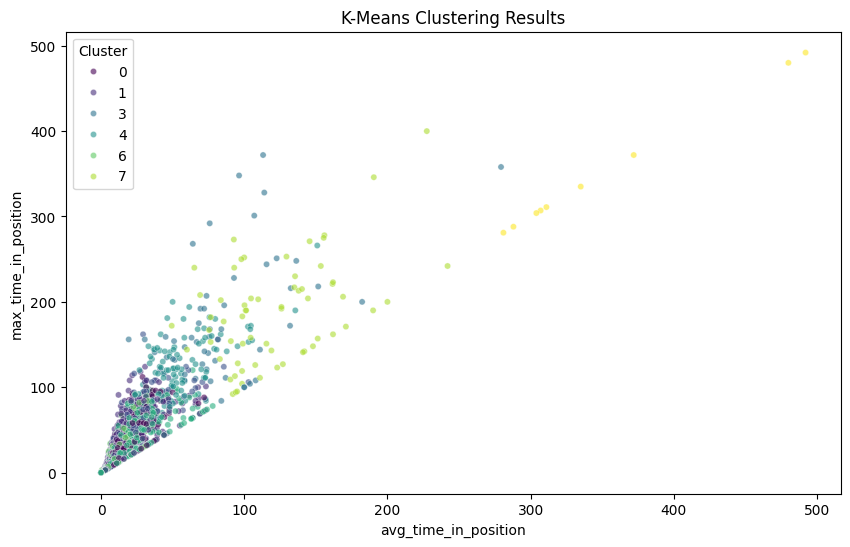

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
x = 'avg_time_in_position'
y = 'max_time_in_position'
sns.scatterplot(x=x, y=y, hue='prediction', data=preditions_pd_df, palette='viridis', s=20, alpha=0.6)
plt.title('K-Means Clustering Results')
plt.xlabel(x)
plt.ylabel(y)
plt.legend(title='Cluster')
plt.show()

In [ ]:
spark.stop()
# Delete tmp directory
shutil.rmtree(temp_dir)
logger.info('successfully stopped spark and remove tmp dir')